In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pydot

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [ ]:
train_data= pd.read_csv("/content/drive/MyDrive/Sentiment analysis/new_lstm.csv", encoding= 'unicode_escape')
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['Sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['review'] = train_data['review'].apply(remove_emoji)
train_data['review'] = train_data['review'].apply(remove_url)
train_data['review'] = train_data['review'].apply(clean_text)


test_data= pd.read_csv("/content/drive/MyDrive/Sentiment analysis/new_lstm_test.csv", encoding= 'unicode_escape')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['Sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['review'] = test_data['review'].apply(remove_emoji)
test_data['review'] = test_data['review'].apply(remove_url)
test_data['review'] = test_data['review'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
 0    100
-1    100
 1     99
Name: Sentiment, dtype: int64
299
-------------------------
-------Test data--------
 1    63
 0    19
-1    17
Name: Sentiment, dtype: int64
99
-------------------------
Train Max Sentence Length :411
Test Max Sentence Length :411


In [ ]:
num_words = 20000
tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['review'].tolist())
print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 143, 46, 47]]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review'].tolist(),\
                                                      train_data['Sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['Sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['Sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:269
Class distributionCounter({-1: 90, 0: 90, 1: 89})
Valid data len:30
Class distributionCounter({-1: 10, 1: 10, 0: 10})
[ 172   11  233   42  293    5 1487  291    3  757  258 1488    3  754
  125  107   35   42  467    3  942 1489    9   13  188   87  820  258
  943   10  163 1490   37  707  960  456  258  896   53  213]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtyp

In [ ]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[-1, 0, 0, 0, 0, -1, 0, 0, -1, 1]
Text to number
[0 1 1 1 1 0 1 1 0 2]
Number to category
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[ 172   11  233   42  293    5 1487  291    3  757  258 1488    3  754
  125  107   35   42  467    3  942 1489    9   13  188   87  820  258
  943   10  163 1490   37  707  960  456  258  896   53  213], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  47    5 1324  146 2392  159 1057  547  118   47  439 2393    2  938
  159 2394   51    5  506  103  178 2395 2396  653  105  429  603  694
 1305   20 2397    2   31   20  153   57  328  267 2398 1325], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[   3  107 1570   37  204  633  795  203 1571  142  102  230  133  182
  122   35    7   58  327   37  184    9  121    2  535   98  182    5
   13 1572    6  121 1573   16  169   98  252    7   51   89], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
======Validation dataset ====
tf.Tensor(
[  14  493  187  117   19  558   55   29   26  103  164    7 

In [ ]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
______________________________________________

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 2s 249ms/step - loss: 1.6679 - categorical_accuracy: 0.3271 - val_loss: 1.6037 - val_categorical_accuracy: 0.3333
Epoch 2/100
3/3 [==============================] - 0s 77ms/step - loss: 1.5865 - categorical_accuracy: 0.4238 - val_loss: 1.5466 - val_categorical_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 70ms/step - loss: 1.5173 - categorical_accuracy: 0.4684 - val_loss: 1.4919 - val_categorical_accuracy: 0.4333
Epoch 4/100
3/3 [==============================] - 0s 69ms/step - loss: 1.4539 - categorical_accuracy: 0.5019 - val_loss: 1.4411 - val_categorical_accuracy: 0.4333
Epoch 5/100
3/3 [==============================] - 0s 80ms/step - loss: 1.3988 - categorical_accuracy: 0.5353 - val_loss: 1.3952 - val_categorical_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 69ms/step - loss: 1.3424 - categorical_accuracy: 0.5799 - val_loss: 1.3537 - val_categorical_accuracy: 0.4667
Epoch 7/100
3/3 [==========

In [ ]:
history.history

{'loss': [1.667923092842102,
  1.58647882938385,
  1.5172524452209473,
  1.4538846015930176,
  1.3988443613052368,
  1.3423595428466797,
  1.3008404970169067,
  1.2511892318725586,
  1.210174798965454,
  1.1739977598190308,
  1.1463102102279663,
  1.1219195127487183,
  1.1068212985992432,
  1.0814005136489868,
  1.0574681758880615,
  1.0441654920578003,
  1.0248041152954102,
  1.0163034200668335,
  1.00206458568573,
  0.9805471301078796,
  0.9684748649597168,
  0.9459186792373657,
  0.9472353458404541,
  0.9231187105178833,
  0.9046710133552551,
  0.9064063429832458,
  0.8797308206558228,
  0.8735530972480774,
  0.8478203415870667,
  0.8336120247840881,
  0.8031699657440186,
  0.7974397540092468,
  0.7870532274246216,
  0.7506693005561829,
  0.7321719527244568,
  0.7265849113464355,
  0.6938184499740601,
  0.6790933609008789,
  0.6617052555084229,
  0.6373703479766846,
  0.6267004013061523,
  0.5998973250389099,
  0.5908747911453247,
  0.5598360896110535,
  0.5355468988418579,
  0.5345

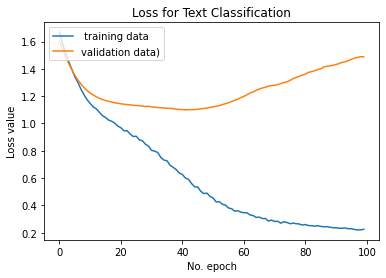

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#plt.plot(history.history['CategoricalAccuracy'], label=' (training data)')
#plt.plot(history.history['val_CategoricalAccuracy'], label='CategoricalCrossentropy (validation data)')
#plt.title('CategoricalAccuracy for Text Classification')
#plt.ylabel('CategoricalAccuracy value')
#plt.xlabel('No. epoch')
#plt.legend(loc="upper left")
#plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Sentiment analysis/model-CNN/tf_cnnmodel') 
json_string = tokenizer.to_json()

In [ ]:
import json
with open('/content/drive/MyDrive/Sentiment analysis/model-CNN/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Sentiment analysis/model-CNN/tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
______________________________________________

In [ ]:
with open('/content/drive/MyDrive/Sentiment analysis/model-CNN/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer1.texts_to_sequences(test_data['review'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.9156379  0.18846163 0.16124886]
 [0.17165193 0.91872    0.16793975]
 [0.14258933 0.96735966 0.08749092]
 [0.22694746 0.54598755 0.7551863 ]
 [0.21552286 0.33560532 0.9302118 ]
 [0.14990073 0.21295133 0.97471607]
 [0.26239032 0.28652138 0.9232025 ]
 [0.5868405  0.40728116 0.44113788]
 [0.23597935 0.2408295  0.9449494 ]
 [0.13533393 0.3471122  0.96032155]
 [0.20780164 0.24925369 0.9509476 ]
 [0.1829921  0.29444563 0.9517988 ]
 [0.11811575 0.9496334  0.18689048]
 [0.14443588 0.9481591  0.16697589]
 [0.24086231 0.30249593 0.9172598 ]
 [0.10842425 0.3581261  0.96107054]
 [0.20971385 0.244609   0.96426606]
 [0.22232875 0.9039273  0.12688658]
 [0.13582125 0.92118585 0.24800378]
 [0.10008445 0.37419164 0.9630929 ]
 [0.9437878  0.13406178 0.19232735]
 [0.12551293 0.41801542 0.94694054]
 [0.94489455 0.11570692 0.23411226]
 [0.9544225  0.15781316 0.116487  ]
 [0.25270417 0.24689224 0.94766724]
 [0.12023476 0.24155352 0.9784275 ]
 [0.16490754 0.20336491 0.9

In [ ]:
predict_results

array([0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       0, 0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 2, 2, 1,
       2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 0, 0, 2, 2, 2, 0, 0, 1, 2, 1])

In [ ]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),-1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 1),0,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 2),1,test_data.pred_sentiment)

In [ ]:
test_data['pred_sentiment']

0    -1
1     0
2     0
3     1
4     1
     ..
94   -1
95   -1
96    0
97    1
98    0
Name: pred_sentiment, Length: 99, dtype: int64

In [ ]:
labels = [-1,0,1]
    
print(classification_report(test_data['Sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

          -1       0.84      0.94      0.89        17
           0       0.89      0.84      0.86        19
           1       0.97      0.95      0.96        63

    accuracy                           0.93        99
   macro avg       0.90      0.91      0.90        99
weighted avg       0.93      0.93      0.93        99



Text(0.5, 145.31999999999996, 'Predicted')

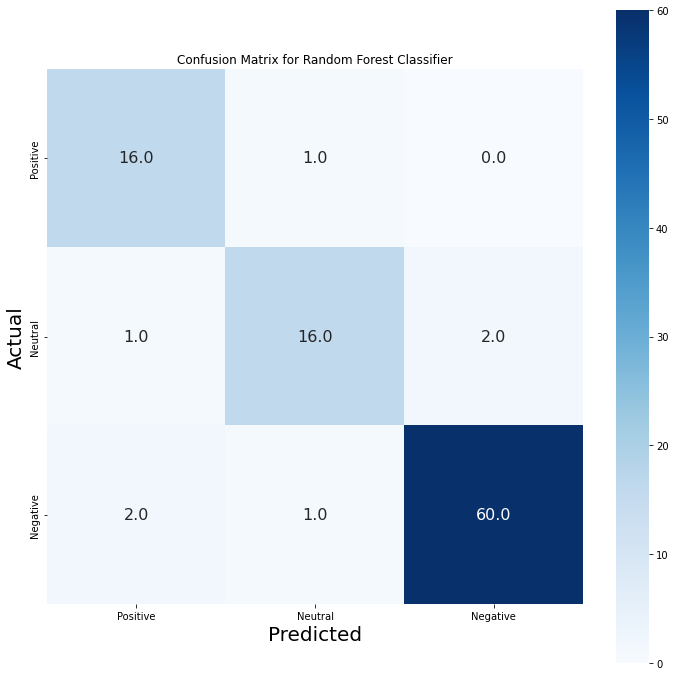

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
Ypred = test_data['pred_sentiment']
label=['Positive', 'Neutral','Negative']
Ytrue = test_data['Sentiment']
cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
plt.title("Confusion Matrix for Random Forest Classifier")
ax = sns.heatmap(cm, cmap="Blues", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

ROC AUC score: 0.9364202941196448


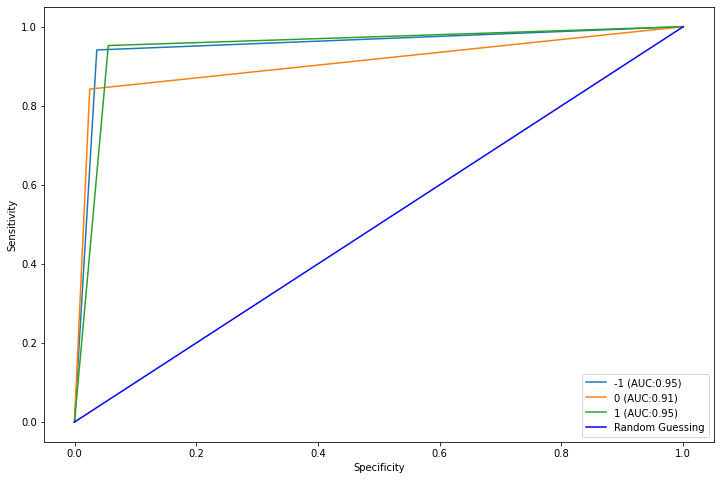

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [-1,0,1]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(Ytrue, Ypred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(Ytrue)
    Ytrue = lb.transform(Ytrue)
    Ypred = lb.transform(Ypred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(Ytrue[:,idx].astype(int), Ypred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(Ytrue, Ypred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Ytrue, Ypred))

c_ax.legend()
c_ax.set_xlabel('Specificity')
c_ax.set_ylabel('Sensitivity')
plt.show()